In [64]:
# Author: Francisco Sepúlveda
# Crypto Efficient portfolio calculator


# Import external libraries
from this import d
from time import time
from binance.client import Client
from pypfopt import EfficientFrontier, risk_models, expected_returns, plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class BinanceCryptoPorfolio():
    def __init__(self, freq=365, weight_bounds=(0, 1)) -> None:
        self.client = Client()
        self.freq = freq
        self.weight_bounds= weight_bounds
        

    def get_trading_pair(self, base_coin):
        
        df = pd.DataFrame(self.client.get_all_tickers())
        df = df[df.symbol.str.contains(f'{base_coin}$', regex = True)]
        
        return list(df['symbol'])


    def get_daily_data(self, currency_pairs, interval = '1d', period = '3 years ago UTC'):     
        print('This takes a little bit due binance restriction for gathering data :-)')
        df_array = []
        for currency_pair in currency_pairs:

            df = pd.DataFrame(self.client.get_historical_klines(currency_pair, interval, 
                                period))        #Pull /Symbol: BTC-USDT / Interval: 1 Day / Period: 3 Years
            
            if df.shape[1] != 12:
                print(f'currency pair {currency_pair} skipped due data problems')
                continue

            df = df[[0,4]]                      #[Timestamp, close Time]
            df = df.fillna(0)
            df.columns = ['Timestamp', currency_pair]
            df.set_index('Timestamp', inplace = True)
            df.index = pd.to_datetime(df.index,unit="ms")
            
            df = df.astype(float)
            df_array.append(df)
        # Removes pairs with missing data in period
        df_out = pd.concat(df_array, axis=1)
        df_out.dropna(axis=1, inplace = True)
        print("done!")
       
        return df_out

    def get_return_volatily(self, df_historical_returns):
        mu = expected_returns.mean_historical_return(df_historical_returns, frequency=self.freq)  #Mu: Mean of historical returns
        sigma = risk_models.sample_cov(df_historical_returns, frequency=self.freq)                #sigma: Volatility (covariance)
        
        return (mu, sigma)
    
    def get_tangency_portfolio(self, mu, sigma):
        ef = EfficientFrontier(mu, sigma, weight_bounds=self.weight_bounds)
        weights = ef.max_sharpe()
        ret_tangent, std_tangent, _ = ef.portfolio_performance()
        return ret_tangent, std_tangent, weights


        
    def efficient_frontier_plot(self, mu, sigma):    
        #for plotting
        ef = EfficientFrontier(mu, sigma, weight_bounds= self.weight_bounds)
        tickers = ef.tickers
        assets_volatility = np.diag(ef.cov_matrix) ** (0.5)
        fig, ax = plt.subplots(figsize = (16,9))
        plotting.plot_efficient_frontier(ef, ax=ax, show_assets = True)
        for i, txt in enumerate(tickers):
            ax.annotate(txt, (assets_volatility[i], ef.expected_returns[i]))
        return fig, ax
    
 
    

In [65]:
BASE_COINS = ['USDT', 'BTC', 'ETH']
bcp = BinanceCryptoPorfolio()

In [66]:
#if we want to change the base coin the appropiate index shall be selected
index = 0
trading_pairs = bcp.get_trading_pair(BASE_COINS[index]) # using USDT
print(f'There are {len(trading_pairs)} pairs for {BASE_COINS[index]}')

There are 404 pairs for USDT


In [67]:
print(f'trading pairs aviable:\n {trading_pairs}')

trading pairs aviable:
 ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'BCCUSDT', 'NEOUSDT', 'LTCUSDT', 'QTUMUSDT', 'ADAUSDT', 'XRPUSDT', 'EOSUSDT', 'TUSDUSDT', 'IOTAUSDT', 'XLMUSDT', 'ONTUSDT', 'TRXUSDT', 'ETCUSDT', 'ICXUSDT', 'VENUSDT', 'NULSUSDT', 'VETUSDT', 'PAXUSDT', 'BCHABCUSDT', 'BCHSVUSDT', 'USDCUSDT', 'LINKUSDT', 'WAVESUSDT', 'BTTUSDT', 'USDSUSDT', 'ONGUSDT', 'HOTUSDT', 'ZILUSDT', 'ZRXUSDT', 'FETUSDT', 'BATUSDT', 'XMRUSDT', 'ZECUSDT', 'IOSTUSDT', 'CELRUSDT', 'DASHUSDT', 'NANOUSDT', 'OMGUSDT', 'THETAUSDT', 'ENJUSDT', 'MITHUSDT', 'MATICUSDT', 'ATOMUSDT', 'TFUELUSDT', 'ONEUSDT', 'FTMUSDT', 'ALGOUSDT', 'USDSBUSDT', 'GTOUSDT', 'ERDUSDT', 'DOGEUSDT', 'DUSKUSDT', 'ANKRUSDT', 'WINUSDT', 'COSUSDT', 'NPXSUSDT', 'COCOSUSDT', 'MTLUSDT', 'TOMOUSDT', 'PERLUSDT', 'DENTUSDT', 'MFTUSDT', 'KEYUSDT', 'STORMUSDT', 'DOCKUSDT', 'WANUSDT', 'FUNUSDT', 'CVCUSDT', 'CHZUSDT', 'BANDUSDT', 'BUSDUSDT', 'BEAMUSDT', 'XTZUSDT', 'RENUSDT', 'RVNUSDT', 'HCUSDT', 'HBARUSDT', 'NKNUSDT', 'STXUSDT', 'KAVAUSDT', 'ARPAUSDT', 'IOTX

In [42]:
trading_data = bcp.get_daily_data(trading_pairs)

This takes a little bit due binance restriction for gathering data :-)
currency pair BCCUSDT skipped due data problems
currency pair VENUSDT skipped due data problems
currency pair BCHSVUSDT skipped due data problems
done!


In [53]:
trading_data.head(10)

,BTCUSDT,ETHUSDT,BNBUSDT,NEOUSDT,LTCUSDT,QTUMUSDT,ADAUSDT,XRPUSDT,EOSUSDT,TUSDUSDT,...,ZECUSDT,IOSTUSDT,CELRUSDT,DASHUSDT,OMGUSDT,THETAUSDT,ENJUSDT,MITHUSDT,MATICUSDT,ATOMUSDT
Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-05-17,7355.26,244.30,25.7795,11.265,89.76,2.887,0.08275,0.38862,6.0353,0.9983,...,73.34,0.012296,0.01352,139.49,1.9900,0.11400,0.16189,0.03895,0.01455,4.413
2019-05-18,7257.45,233.60,28.8171,10.700,86.51,2.826,0.07872,0.37183,5.8813,0.9987,...,71.91,0.011807,0.01247,141.03,1.8872,0.11934,0.14734,0.04589,0.01235,4.684
2019-05-19,8148.48,259.51,29.1122,11.655,94.58,3.140,0.08613,0.41631,6.4581,0.9938,...,77.60,0.012385,0.01727,172.14,2.0995,0.11620,0.15288,0.04674,0.02018,4.852
2019-05-20,7938.15,250.37,29.2666,11.998,91.10,3.090,0.08439,0.39636,6.2144,0.9927,...,75.95,0.012061,0.02114,166.45,2.0274,0.11300,0.15303,0.05399,0.02950,4.673
2019-05-21,7904.87,253.43,32.3907,12.079,90.79,3.153,0.08403,0.39524,6.2589,0.9939,...,74.51,0.012920,0.01793,165.71,2.1054,0.11373,0.17000,0.05112,0.02953,4.743
2019-05-22,7628.43,243.64,30.8067,11.154,87.74,2.853,0.07749,0.37183,5.9285,1.0007,...,69.73,0.011500,0.01363,153.87,1.9122,0.10550,0.15488,0.04590,0.02209,4.306
2019-05-23,7851.51,244.56,31.3934,11.411,88.61,2.872,0.08034,0.37956,6.0157,0.9966,...,71.91,0.011714,0.01466,154.06,1.9059,0.10916,0.16721,0.04651,0.02739,4.337
2019-05-24,7964.87,248.87,33.9435,11.519,100.50,2.916,0.08062,0.38286,6.4064,0.9955,...,72.38,0.012067,0.01354,155.80,1.9722,0.11820,0.16081,0.04887,0.02529,4.454
2019-05-25,8025.41,250.22,35.0168,11.416,102.66,2.899,0.08006,0.38520,6.3603,0.9945,...,72.30,0.012152,0.01384,156.02,1.9636,0.13695,0.16634,0.05040,0.02475,4.385


<Figure size 1152x648 with 0 Axes>

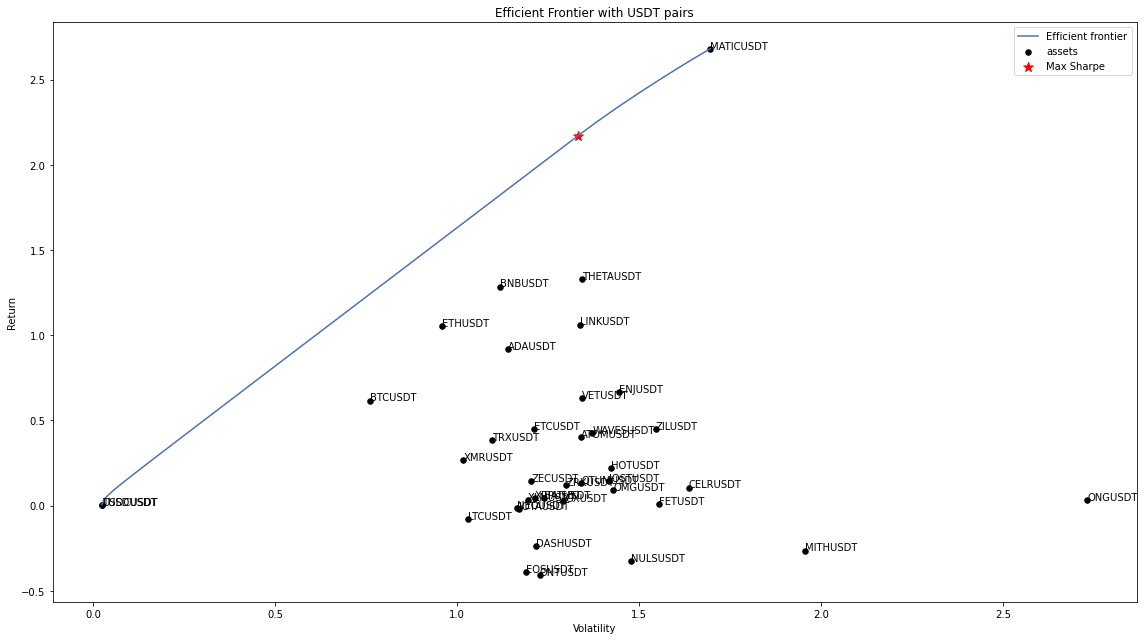

In [68]:
plt.figure(figsize=(16,9))
mu, sigma = bcp.get_return_volatily(trading_data)
ret_tn, std_tn, weights = bcp.get_tangency_portfolio(mu, sigma)

fig, ax = bcp.efficient_frontier_plot(mu, sigma)
ax.scatter(std_tn, ret_tn, marker="*", s=100, c="r", label="Max Sharpe")

ax.set_title(f"Efficient Frontier with {BASE_COINS[index]} pairs")
ax.legend()
plt.tight_layout()

plt.show()

In [75]:
print('The optimal (return) portfolio is given by: /n')
for coin_pair in weights:
    if weights[coin_pair] <=0:
        continue
    print(f'{coin_pair}: {weights[coin_pair]*100:.2f}%')

The optimal (return) portfolio is given by: /n
ETHUSDT: 0.55%
BNBUSDT: 21.44%
THETAUSDT: 14.87%
MATICUSDT: 63.14%
